# CMSE 381 Final Project

#### CMSE 381 Final Project
### &#9989; Group members: Colby Degan, Jose Villegas
### &#9989; Section_002
#### &#9989; 4/25/2025

# Concrete Crack Detection using SVCs and CNNs

## Background and Motivation

 When it comes to classification problems in Data Science and Machine Learning, the utility of images can often be very useful to do so. For this particular project, a large directory of images was provided, within the directory there were two sub-directories split into categories of Cracked, and Non-cracked, then within those directories there were nested directories that consisted of the type, or structure of concrete, which were of the following: pavement, deck, and wall. Our overall goal was to consider two machine learning processes/algorithms that we learned in class, and apply those models to these different kinds of images to make a model that can optimally classify whether or not images are cracked. After these models are created, these models will be optimized utilizing some form of cross validation to make improvements.

## Methodology
There were two approaches that we utilized to create our models, the first of which was an Support Vector Classifier that was run on each of the three different structures, then the optimization approach was done using the GridSearchCV class from Sklearn. the other approach was done thorough A Convolutional neural network. Which is a neural network that excels in image classification, and attempts to mimic similar classification approaches that humans make. The optimization to the CNN will be to utilize gridsearch or apply dropout regularization to optimize the CNN.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image

import torch
from torch import nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.utils.data import random_split
from itertools import product

### Data

We are compressing each 256x256 image into 16x16, and are using each pixel measurement of that compressed image as a variable, giving us 256 pixel measurements. We are also using the type of structure as a variable, as it wouldn't be logical to compare a picture of cracked pavement to a picture of an un-cracked wall.

In [ ]:

folder_paths = ["archive/Decks/Cracked", "archive/Decks/Non-cracked", "archive/Pavements/Cracked", "archive/Pavements/Non-cracked", "archive/Walls/Cracked", "archive/Walls/Non-cracked"]
image_data = []
cracked = []
structure = []

# For every folder that contains images
for folder_path in folder_paths:

    # Get list of image files
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

    # Initialize list to store image data
    for i in range(len(image_files)):
        img_path = os.path.join(folder_path, image_files[i])
        img = Image.open(img_path).convert('L')
        img.thumbnail((16, 16), Image.Resampling.LANCZOS)
        img_array = np.array(img).flatten()
        image_data.append(img_array)
        if folder_path == "archive/Decks/Cracked" or folder_path == "archive/Decks/Non-cracked":
            structure.append("Deck")
        elif folder_path == "archive/Pavements/Cracked" or folder_path == "archive/Pavements/Non-cracked":
            structure.append("Pavement")
        else:
            structure.append("Wall")
        if folder_path == "archive/Decks/Cracked" or folder_path == "archive/Pavements/Cracked" or folder_path == "archive/Walls/Cracked":
            cracked.append(1)
        else:
            cracked.append(0)


df = pd.DataFrame(image_data)
df["Structure"] = structure
df["Cracked"] = cracked
df.to_csv("concrete_dataset_16.csv", index=False)

In [ ]:
class ConcreteDataset(Dataset):
    """ Object set to take in images from the provided dataset

        The reason for this Class is to be able to utilize DataLoaders for the CNN model, 
        two different approaches were used to read in the data depending on the model being used.
    """
    def __init__(self, folder_paths, transform=None):
        """ Initialization function consisting of:

        - image data: 
        - Cracked: list for all cracked images (1) or non-cracked (0)
        - structure: list for structure types in concrete (wall, pavement, decks)
        """
        self.image_data = []
        self.cracked = []
        self.structure = []
        self.transform = transform
        
        # For each folder (cracked or non-cracked)
        for folder_path in folder_paths:
            # Get list of image files
            image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

            for filename in image_files:
                img_path = os.path.join(folder_path, filename)
                img = Image.open(img_path).convert('L')  # Grayscale image
                img.thumbnail((16, 16), Image.Resampling.LANCZOS)
                img_array = np.array(img)  # Keep as 2D array

                # Pad to exactly 64x64 if needed
                if img_array.shape != (16, 16):
                    padded_img = np.zeros((16, 16), dtype=np.uint8)
                    padded_img[:img_array.shape[0], :img_array.shape[1]] = img_array
                    img_array = padded_img

                # Append image data
                self.image_data.append(img_array)
                
                # Append structure type
                self.structure.append(folder_path.split('/')[0])  # Extract structure (Deck, Pavement, Wall)
                
                # Append cracked/non-cracked label
                if 'Cracked' in folder_path:
                    self.cracked.append(1)
                else:
                    self.cracked.append(0)

    def __len__(self):
        """ Helpful length function to get size of Dataset Easily """
        return len(self.image_data)
                    
    def __getitem__(self, idx):
        """ This function allows for easy access of the data's  image at a particular index
            and the images' respective label, 0 representing Cracked, and 1 representing Non-Cracked
        """
        image = self.image_data[idx]
        label = self.cracked[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [ ]:
folder_paths = [
    "Decks/Cracked", "Decks/Non-cracked", 
    "Pavements/Cracked", "Pavements/Non-cracked", 
    "Walls/Cracked", "Walls/Non-cracked"
]
image_data = []
cracked = []
structure = []

# Creating a transformation pipeline which normalizes images to get into correct range
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [0, 1] range
])


In [ ]:
Concrete_Images = ConcreteDataset(folder_paths, transform=transform)

train_size = int(0.8 * len(Concrete_Images))  # 80% for training
test_size = len(Concrete_Images) - train_size
train_dataset, test_dataset = random_split(Concrete_Images, [train_size, test_size])

# Utilizing dataloaders in order to process batches of images instead of attempting to do it all at once
# this makes things less computationally expensive
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [2]:
concrete_dataset = pd.read_csv('concrete_dataset_16.csv')
concrete_dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,Structure,Cracked
0,179,172,172,179,177,180,181,179,175,178,...,177,181,185,183,186,191,183,181,Deck,1
1,181,182,176,178,180,177,180,179,181,186,...,185,185,180,179,186,177,182,180,Deck,1
2,182,188,187,196,193,190,185,185,188,188,...,189,187,189,191,186,192,190,189,Deck,1
3,199,194,176,175,186,186,184,184,179,170,...,181,177,182,178,178,181,179,177,Deck,1
4,176,180,179,182,177,179,177,178,178,181,...,180,175,174,180,179,178,181,182,Deck,1


In [3]:
concrete_dataset = pd.get_dummies(concrete_dataset, drop_first = True)
concrete_dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,Cracked,Structure_Pavement,Structure_Wall
0,179,172,172,179,177,180,181,179,175,178,...,181,185,183,186,191,183,181,1,False,False
1,181,182,176,178,180,177,180,179,181,186,...,185,180,179,186,177,182,180,1,False,False
2,182,188,187,196,193,190,185,185,188,188,...,187,189,191,186,192,190,189,1,False,False
3,199,194,176,175,186,186,184,184,179,170,...,177,182,178,178,181,179,177,1,False,False
4,176,180,179,182,177,179,177,178,178,181,...,175,174,180,179,178,181,182,1,False,False


### Models for classification

#### SVC with GridSearchCV

We chose this because we thought it would be useful for image classification. By using GridSearchCV we are able to check what the best possible parameters are for the model. We will evaluate this model by checking its training and testing errors to see how well the model performs.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

# Obtain X and y data from dataset
X = concrete_dataset.drop(columns = ["Cracked"])
y = concrete_dataset.Cracked

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

# Scales the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handles imbalances within the data
smote = SMOTE(random_state = 42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Runs Grid Search with multiple different parameters to find the best parameters for the data
svc = SVC(class_weight='balanced', random_state=42)
param_grid = {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear'], 'gamma': ['scale', 'auto', 0.1]}
grid_search = GridSearchCV(svc, param_grid, cv = 5, scoring = 'accuracy', n_jobs = -1)
grid_search.fit(X_train_balanced, y_train_balanced)

# Chooses the best SVC found from the best parameters
best_svc = grid_search.best_estimator_

#### CNN with Nested Loop Hyperparameter Search

We chose this because we thought it would be useful to identify smaller changes in the model, which is useful for noticing small cracks. We were unable to properly use GridSearchCV for the CNN and Pytoarch and Sklearn are incompatible. To get around this we wrote a custom nested loop hyperparameter search to determine the best hyperparameters for the CNN. We will evaluate the CNN using accuracy

In [ ]:
CNN_model = nn.Sequential(
    # This is the Convolutional Layer, with the single input being the image itself, however the image itself
    # Is a 4 dimensional Tensor object, as this is how Pytorch CNNs are implemented
    # The kernel size is representative of the matrix that actually does the convolving over the input
    nn.Conv2d(1, 16, kernel_size=3, padding=1),
    nn.ReLU(), # Using ReLU 
    nn.MaxPool2d(kernel_size=2, stride=2), # Pooling layer to find the maximum value to represent the 2x2 pooling sample of our image

    # A hidden Convolutional layer reading the output of the previous (size 16) and using a similar kernel size to convolve over current image
    nn.Conv2d(16, 32, kernel_size=3, padding=1),
    nn.ReLU(), # ReLU once again as activation
    nn.MaxPool2d(kernel_size=2, stride=2), # Pooling layer used to similar find max of 2x2 pooling matrix

    nn.Flatten(),  # Using flatten to turn 32, 16, 16 into a single value
    nn.Linear(32 * 4 * 4, 64),
    nn.ReLU(), # ReLU!
    nn.Linear(64, 1)  # One output for binary classification
)
    

In [ ]:
# torch device is able to use GPU to run model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN_model = CNN_model.to(device)


criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(CNN_model.parameters(), lr=0.001)

### Initial Model Training

In [ ]:
num_epochs = 5

# Each epoch iteration
for epoch in range(num_epochs):

    # Training CNN
    CNN_model.train()

    # Loss variable to track total loss
    running_loss = 0.0

    # Now iterating through dataloader to limit image processing to make more managable
    for images, labels in train_loader: 

        # Moving the images and labels to the same device as model for computations
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        #
        optimizer.zero_grad()
        outputs = CNN_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {running_loss:.4f}")

### Evaluation of model

In [ ]:
CNN_model.eval()
correct = 0
total = 0

all_predicts = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        predictions = torch.sigmoid(outputs) > 0.5
        
        all_predict.extend(predictions.cpu().numpy())
        all_labelsextend(labels.cpu().numpy())
        
accuracy = sum(np.array(all_predicts) == np.array(all_labels)) / len(all_labels)
print(f"Accuracy: {100 * accuracy:.2f}%")

print(classification_report(all_labels, all_predicts, target_named=["Uncracked", "Cracked"]

# CNN with Manual Grid Search optimization

The Benefit to using A grid seach validation method would be to find the most optimal selection of parameters, those that were considered were, optimizer, batch size, and learning rate. The reason this approach was used is because of one main issue, Sklearns gridsearch doesn't have a direct application with pytorch, and because of this, the product function is used from itertools to create matrix of different learning rates, batches, and optimizers to find an optimal model, this will run several CNNs over the course of what is likely a long time. The results were evaluated by getting the ratio of correctly classified images over the total number of images looked at.

In [ ]:
learning_rates = [0.01, 0.001]
batches = [16, 32, 64]

grid_iter = list(product(learning_rates, batches))

In [ ]:
results = []

for lr, curr_batch, opt in grid_iter:
    print(f"\n Current learning rate: {lr}, batch size: {curr_batch}, Optimizer: {opt}")

    
    # The reason for making different loaders for every instance is due to the different batch sizes to find most optimal hyperparameter
    curr_loader = DataLoader(Concrete_Images, batch_size = curr_batch, shuffle = True)


    # Creating a model for the multiple iterations
    curr_model = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Flatten(),
        nn.Linear(32 * 16 * 16, 64),
        nn.ReLU(),
        nn.Linear(64, 1)
    ).to(device)

    # Need to have specific conditions to use different optimizers when neccessary 

    optimizer = optim.Adam(curr_model.parameters(), lr=lr)

    # Need our binary classifier using Binary classification log loss function
    criterion = nn.BCEWithLogitsLoss()

    # Now we need to actually train our model(s) will be done with set amount of epochs (5)
    for epoch in range(5):

        # Call train function on the 
        curr_model.train()
        constant_loss = 0.0

        # Now iterate through the images and their respective layers through our DataLoader for Concrete data
        for images, labels in curr_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            # Reset gradients so each model doesn't have incorrect gradients
            optimizer.zero_grad()

            # Store outputs as model run on images
            outputs = curr_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Add to constant loss to get overall loss by end of model run
            constant_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {constant_loss:.4f}")
    
    correct = 0
    total = 0
    curr_model.eval()

    # Code to get accuracy of particular model
    with torch.no_grad():
        for images, labels in curr_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)
    
            outputs = curr_model(images)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    accuracy = correct / total
    print(f"Accuracy: {accuracy:.4f}")
    results.append({
        'lr': lr,
        'batch_size': curr_batch,
        'optimizer': opt,
        'accuracy': accuracy
    })

## Results

### SVC results

The most optimal SVC found by GridSearchCV obtain an accuracy of around 78.3% when using the scaled, balanced data. This isn't necessarily a bad accuracy, but we would prefer to have one higher, preferably around 90%. The precision, recall, and f1-score for no crack being found were 0.87, 0.88, and 0.87, respectively, while those for a crack being found were 0.26, 0.23, and 0.24. This is likely due to there being more images of concrete without cracks than those with cracks, as evidenced by the support values of 9522 for no cracks found and 1697 for a crack being found.

We additionally generated a confusion matrix to better understand and visualize the model's performance across the classes. The confusion matrix showcases that there were 1128 false positives and 1308 false negatives. It also shows that around 88.2% of the images without cracks were identified correctly, while only 22.9% of the images with cracks were identified correctly. As mentioned earlier this is likely due to the difference in size between the two classes. Another likely cause of this are the small, complex patterns that cracks cause in the image data, which SVCs have a hard time noticing.

Accuracy: 0.7828683483376415

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.88      0.87      9522
           1       0.26      0.23      0.24      1697

    accuracy                           0.78     11219
   macro avg       0.56      0.56      0.56     11219
weighted avg       0.77      0.78      0.78     11219


Confusion Matrix:
 [[8394 1128]
 [1308  389]]


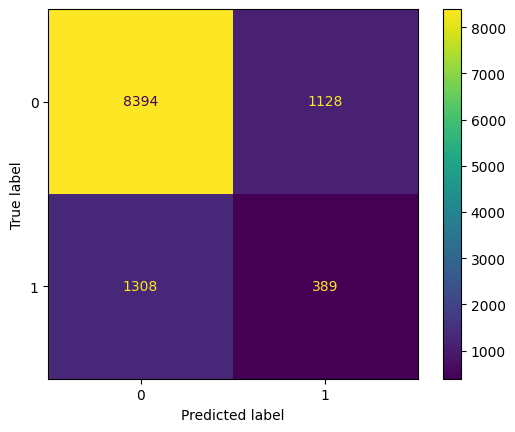

In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = best_svc.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

### CNN results

The initial model had a learning rate of 0.001, using the Adam optimizer, and a batch size of 32

This model didn’t perform that poorly, but a question of which hyperparameters were best was yet to be answered. Because of this the optimization process would then turn into a gridsearch process where multiple arrays of hyperparameters would be used to run multiple different models, because of the large amount of Neural Networks this would create, some things had to be toned down, like number of epochs for example. Along with this in order to reduce runtime, images were scaled down to 16x16 pixels. This may have led to some incorrect classifications but also resulted in quicker results. Unfortunately, the typical parameters used to assess neural networks, that being f1-score, precision, and recall were not programmed in before running the model, so going based off accuracy of classification is the only parameter being discussed.


The initial model is on the left, which had an okay accuracy of 86%, with 10 epochs to run through. The optimized model(s) however have varying results, The model with the configuration Adam, learning rate 0.01, and batch size 64 had the greatest overall loss, whereas the SGD, 0.01, 64, configuration maintained consistency, but was slower than the Adam variation. A model that does not do very well is the model with optimizer SGD, learning rate 0.01, and batch size 16, as the loss drop is not a significant, which indicates that the model is not learning as well, this may be due to the small batch sizes not doing well with the faster learning rate.


In [ ]:
results_16 = {
    ("SGD", 0.01, 16): [1445.4743, 1441.6831, 1438.9502, 1437.0728, 1433.2455],
    ("Adam", 0.01, 16): [1475.2849, 1460.9638, 1460.2559, 1459.9407, 1460.0902],
    ("SGD", 0.001, 16): [1492.5712, 1444.7881, 1443.2383, 1442.3714, 1441.5324],
    ("Adam", 0.001, 16): [1389.5200, 1279.5868, 1181.0295, 1164.8745, 1148.8653]
}

results_32 = {
    ("SGD", 0.01, 32): [730.2184, 720.4164, 719.2340, 719.3720, 718.7629],
    ("Adam", 0.01, 32): [713.6464, 670.1269, 645.0783, 616.9844, 592.5035]
}

results_64 = {
    ("SGD", 0.01, 64): [366.5066, 360.8374, 359.9431, 359.1196, 358.6196],
    ("Adam", 0.01, 64): [364.7134, 356.2679, 341.4328, 324.2015, 315.0432],
}

In [ ]:
for (opt, lr, bs), losses in results_16.items():
    label = f"{opt}, lr={lr}, bs={bs}"
    plt.plot(range(1, len(losses)+1), losses, label=label)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch for Different Hyperparameters')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
for (opt, lr, bs), losses in results_32.items():
    label = f"{opt}, lr={lr}, bs={bs}"
    plt.plot(range(1, len(losses)+1), losses, label=label)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch for different Hyperparameters")
plt.legend()
plt.grid(True)
plt.tight_layout()

In [ ]:
for (opt, lr, bs), losses in results_64.items():
    label = f"{opt}, lr={lr}, bs={bs}"
    plt.plot(range(1, len(losses)+1), losses, label=label)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch for different Hyperparameters")
plt.legend()
plt.grid(True)
plt.tight_layout()

## Discussion and Conclusion

### Discussion on the SVC Results

Although the best SVC model found by GridSearchCV is moderately good with an accuracy of around 78.3%, it still has a hard time trying to correctly classify images of concrete that have cracks as evidenced by the differences between correctly identified classes (88.2% of non-cracked identified correctly vs. 22.9% of cracked identified correctly). These results could be improved slightly in the future by adding more C values and gamma values to GridSearchCV, as it is possible that a better SVC model could exist for the data.

The SVC had two main challenges when attempting to classify the data. The first was that there was many more images of non-cracked concrete than there was images of cracked concrete. This could be fixed in the future by using a different method to balance the classes more equally. The second challenge was the small and complex patterns within the images causing the divide between classes. This issue is hard to fix using an SVC as these patterns are hard for the SVC's kernel functions to capture effectively. The only way to get around this issue would be by using some other model to classify the data, such as a CNN or a more advanced deep learning architecture like a ResNet.

### Discussion on the CNN Results
The optimized model unfortunately had to be cut short, as 48 hours in, we had around 9 CNNs that had run with a selection of different hyperparameters. Some models had a steadily decreasing loss which indicates that the models were learning at an okay rate. Due to the model not being able to test all parameters, we don’t have a full set of results to analyze, and we don’t have all of our assessment parameters to work with either

In the future, this optimization process will have all assessment feature (precision, recall, f1-score and accuracy) implemented in order to analyze the model completely In addition to this, the model would ideally be run on the images in a larger, more interpretable resolution. Not to mention, the selection of hyperparameters will all be evaluated, even if it takes multiple days to run.

## Author contribution

Colby Degan (degancol@msu.edu) - Responsible for making the SVC

Jose Villegas (Villeg45@msu.edu) - Responsible for making the CNN

## References

Geeksforgeeks. (2025). Building a Convolutional Neural Network using PyTorch. https://www.geeksforgeeks.org/building-a-convolutional-neural-network-using-pytorch/

Imbalanced Learn. (n.d.). SMOTE — Version 0.9.0. Imbalanced-Learn.org. https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

Pytorch. PyTorch documentation.  https://pytorch.org/docs/stable/index.html

SciKit Learn. (2019). sklearn.model_selection.GridSearchCV — scikit-learn 0.22 Documentation. Scikit-Learn.org. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html